# AWS Lambda Tutorial #

This tutorial shows how to use our `aws_lambda` manager to execute a wrapped `node` on an AWS Labmda function. Note this requires you have AWS credentials configured. For reference, we also have a [guide](file/doc/source/developer/aws.md) in our documentation.

## Configuring Settings for AWS ##

`Podpac` settings include fields for AWS credentials and bucket information, which are empty by default. Additionally, the `Lambda` class in the `aws_lambda` manager allows developers to specify other credentials and s3 bucket information. 

Note: in either case (settings credentials in `settings` or in `aws_lambda`) the credentials being used have to match what is in `HOME/.aws/`. With that in mind, let's stick to the basic configuration for now...

You'll need to create credentials from the AWS developer console. For more information, see their [documentation](https://docs.aws.amazon.com/general/latest/gr/aws-security-credentials.html). After generating credentials, you must configure your aws cli:

```bash
aws configure # invokes prompt for credentials
# Enter credentials generated on AWS developer console
```

This will store your configuration in the `HOME/.aws/ ` directory. You can refer to that directory later to ensure `podpac.settings` has the correct credentials.

Similarly, these credentials must be configured in `podpac`:

In [1]:
import podpac
from podpac import settings
import _pickle as cPickle
# settings.S3_BUCKET_NAME = $YOUR_BUCKET_NAME
# settings.S3_JSON_FOLDER = 'json/' # Or the S3 folder you'd like JSON to be uploaded to.
# settings.S3_OUTPUT_FOLDER = 'output/' # Or the S3 folder you'd like pickle outputs to be uploaded to.
# settings.AWS_ACCESS_KEY_ID = $YOUR_ACCESS_KEY_ID
# settings.AWS_SECRET_ACCESS_KEY = $YOUR_SECRET_ACCESS_KEY
# settings.AWS_REGION_NAME = $YOUR_REGION_NAME

## SinCoords Example ##

Now that `podpac` has AWS credentials, let's go through an example, which wraps a `SinCoords` node, executes it on our Lambda function, and returns the output `UnitsDataArray`.

In [2]:
sin_coords_node = podpac.core.algorithm.algorithm.SinCoords()
coordinates = podpac.Coordinates.grid(lat=(-90, 90, 180), lon=(90,-90, 180), time='2018_01_01')

In [3]:
aws_lambda_manager = podpac.core.managers.aws_lambda.Lambda(source_node=sin_coords_node)
output = aws_lambda_manager.eval(coordinates)
output

<xarray.UnitsDataArray (lat: 180, lon: 180, time: 1)>
array([[[ 1.439804e-32],
        [ 4.126008e-18],
        ...,
        [-4.126008e-18],
        [-1.439804e-32]],

       [[ 4.126008e-18],
        [ 1.182379e-03],
        ...,
        [-1.182379e-03],
        [-4.126008e-18]],

       ...,

       [[-4.126008e-18],
        [-1.182379e-03],
        ...,
        [ 1.182379e-03],
        [ 4.126008e-18]],

       [[-1.439804e-32],
        [-4.126008e-18],
        ...,
        [ 4.126008e-18],
        [ 1.439804e-32]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 -83.97 ...
  * lon      (lon) float64 90.0 88.99 87.99 86.98 85.98 84.97 83.97 82.96 ...
  * time     (time) float64 2.018e+07
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x1c252355f8>
    units:        None

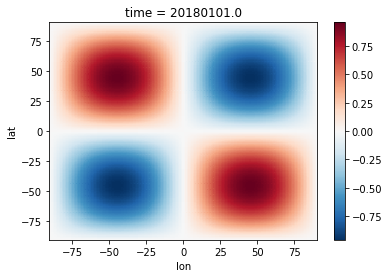

In [5]:
output.plot()
from matplotlib.pyplot import show
show()

## "How the sausage gets made": Recreate this output manually ##

Let's review what `aws_lambda` is actually doing in the example above.

If we take a closer look at `Node` objects, such as `SinCoords`, we'll see a converstion concept to/from either `JSON` or an `OrderedDict`. Similarly, the `Coordinates` object can be converted to/from `JSON`. The `aws_lambda` manager also has an `Output` attribute. You guessed it - this can can be converted to/from `JSON`/`OrderedDict`.

This conversion allows the `aws_lambda` manager to take advantage of `Pipeline`, which allows the AWS `handler` to recreate the wrapped `Node`, `Coordinates`, and `Output` objects provided to the `aws_lambda` manager.

### Generating JSON to evaluate: ###

In [6]:
import json
from collections import OrderedDict
from podpac.core.pipeline.output import FileOutput, Output
d = OrderedDict()
# Note that source_output gets created this way by default in aws_lambda.Lambda
source_output = FileOutput(node=sin_coords_node, name=sin_coords_node.__class__.__name__)
d['pipeline'] = sin_coords_node.definition
d['pipeline']['output'] = source_output.definition
d['coordinates'] = json.loads(coordinates.json)
json.dumps(d)

'{"pipeline": {"nodes": {"SinCoords": {"node": "core.algorithm.algorithm.SinCoords", "inputs": {}}}, "output": {"format": "pickle", "mode": "file", "nodes": ["SinCoords"]}}, "coordinates": [{"start": -90.0, "stop": 90.0, "step": 1.005586592178771, "name": "lat", "coord_ref_sys": "WGS84", "ctype": "midpoint"}, {"start": 90.0, "stop": -90.0, "step": -1.005586592178771, "name": "lon", "coord_ref_sys": "WGS84", "ctype": "midpoint"}, {"values": [20180101.0], "name": "time", "coord_ref_sys": "WGS84", "ctype": "midpoint"}]}'

### Uploading JSON to S3 ###

#### NOTE: Our Lambda function's trigger on S3 should be disabled so we can manually handle this. ####

This JSON should now be uploaded to S3, which will trigger the handler function, as follows:

In [7]:
import boto3
s3 = boto3.client('s3')
file_key = settings.S3_JSON_FOLDER + source_output.name + '.json' # We'll want this later.
s3.put_object(
    Body=(bytes(json.dumps(d, indent=4).encode('UTF-8'))),
    Bucket=settings.S3_BUCKET_NAME,
    Key=file_key
)

{'ResponseMetadata': {'RequestId': '6E47D353A64220FF',
  'HostId': 'Qv3a5JefKsAW6FkAiJWx9wyC62Xfr4mFUNHZPkyMLkDdjy0rzUQZPICNayxAOgQyumJOpiDHKsA=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Qv3a5JefKsAW6FkAiJWx9wyC62Xfr4mFUNHZPkyMLkDdjy0rzUQZPICNayxAOgQyumJOpiDHKsA=',
   'x-amz-request-id': '6E47D353A64220FF',
   'date': 'Wed, 31 Oct 2018 18:41:10 GMT',
   'etag': '"0fd750d1a4a013e26be547fd9502b6d3"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 1},
 'ETag': '"0fd750d1a4a013e26be547fd9502b6d3"'}

#### Wait for pickle file output to S3 ####

##### NOTE: Make sure you've removed the output file from S3 before proceeding. #####

For the `aws_lambda` manager to return an output, it needs to wait for the Lambda function to evaluate. This cell will not finish until the handler has uploaded the output to S3, which we'll do in the next cell down.

In [15]:
from io import BytesIO
waiter = s3.get_waiter('object_exists')
filename = '%s.%s' % (
    source_output.name,
    source_output.format)
waiter.wait(Bucket=settings.S3_BUCKET_NAME, Key=settings.S3_OUTPUT_FOLDER +
            filename)
# After waiting, load the pickle file like this:
resource = boto3.resource('s3')
with BytesIO() as data:
    # Get the bucket and file name programmatically - see above...
    resource.Bucket(settings.S3_BUCKET_NAME).download_fileobj(settings.S3_OUTPUT_FOLDER +
            filename, data)
    data.seek(0)    # move back to the beginning after writing
    output = cPickle.load(data)
output

<xarray.UnitsDataArray (lat: 180, lon: 180, time: 1)>
array([[[ 1.439804e-32],
        [ 4.126008e-18],
        ...,
        [-4.126008e-18],
        [-1.439804e-32]],

       [[ 4.126008e-18],
        [ 1.182379e-03],
        ...,
        [-1.182379e-03],
        [-4.126008e-18]],

       ...,

       [[-4.126008e-18],
        [-1.182379e-03],
        ...,
        [ 1.182379e-03],
        [ 4.126008e-18]],

       [[-1.439804e-32],
        [-4.126008e-18],
        ...,
        [ 4.126008e-18],
        [ 1.439804e-32]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 -83.97 ...
  * lon      (lon) float64 90.0 88.99 87.99 86.98 85.98 84.97 83.97 82.96 ...
  * time     (time) float64 2.018e+07
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x1c2983e9b0>
    units:        None

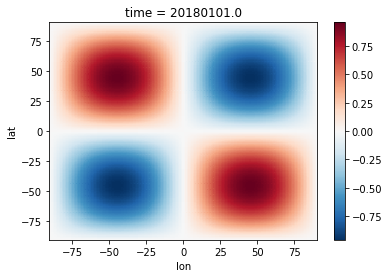

In [16]:
output.plot()

### Evaluating the node ###

The Lambda function has a handler function, which uses the information in the `JSON` uploaded to S3 to evaluate a `Pipeline` node, then uploads that pickle output back to S3.

#### Reading the JSON from S3: ####

In [10]:
# NOTE:
# The handler would parse S3 object metadata from the S3 trigger like this:
# bucket_name = event['Records'][0]['s3']['bucket']['name']
# file_key = urllib.unquote_plus(
#     event['Records'][0]['s3']['object']['key'])
# _json = ''
#
# Howver, we don't need to do that for this example. Instead:

file_key = settings.S3_JSON_FOLDER + source_output.name + '.json'
s3_json = ''
obj = s3.get_object(Bucket=settings.S3_BUCKET_NAME, Key=file_key)
# get lines
lines = obj['Body'].read().split(b'\n')
for r in lines:
    if len(s3_json) > 0:
        s3_json += '\n'
    s3_json += r.decode()
s3_json = json.loads(s3_json, object_pairs_hook=OrderedDict)
json.dumps(s3_json) # This should display the same json string as earlier.

'{"pipeline": {"nodes": {"SinCoords": {"node": "core.algorithm.algorithm.SinCoords", "inputs": {}}}, "output": {"format": "pickle", "mode": "file", "nodes": ["SinCoords"]}}, "coordinates": [{"start": -90.0, "stop": 90.0, "step": 1.005586592178771, "name": "lat", "coord_ref_sys": "WGS84", "ctype": "midpoint"}, {"start": 90.0, "stop": -90.0, "step": -1.005586592178771, "name": "lon", "coord_ref_sys": "WGS84", "ctype": "midpoint"}, {"values": [20180101.0], "name": "time", "coord_ref_sys": "WGS84", "ctype": "midpoint"}]}'

#### Evaluating the pipeline: What happens in the AWS Lambda function ####

In [11]:
pipeline_json = s3_json['pipeline']
pipeline = podpac.core.pipeline.Pipeline(definition=pipeline_json, do_write_output=False) # Don't write the file locally - will upload to S3
coords = podpac.Coordinates.from_json(
    json.dumps(s3_json['coordinates'], indent=4))
output = pipeline.eval(coords)
output

<xarray.UnitsDataArray (lat: 180, lon: 180, time: 1)>
array([[[ 1.439804e-32],
        [ 4.126008e-18],
        ...,
        [-4.126008e-18],
        [-1.439804e-32]],

       [[ 4.126008e-18],
        [ 1.182379e-03],
        ...,
        [-1.182379e-03],
        [-4.126008e-18]],

       ...,

       [[-4.126008e-18],
        [-1.182379e-03],
        ...,
        [ 1.182379e-03],
        [ 4.126008e-18]],

       [[-1.439804e-32],
        [-4.126008e-18],
        ...,
        [ 4.126008e-18],
        [ 1.439804e-32]]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.99 -87.99 -86.98 -85.98 -84.97 -83.97 ...
  * lon      (lon) float64 90.0 88.99 87.99 86.98 85.98 84.97 83.97 82.96 ...
  * time     (time) float64 2.018e+07
Attributes:
    layer_style:  <podpac.core.style.Style object at 0x1c25d53e48>
    units:        None

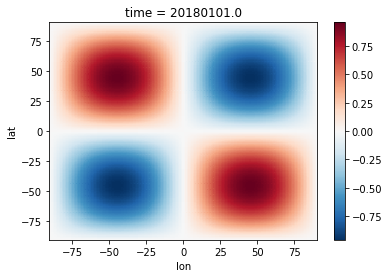

In [12]:
output.plot()

### Uploading the output back to S3 ###

In [13]:
filename = '%s.%s' % (
    pipeline.pipeline_output.name,
    pipeline.pipeline_output.format)
body = cPickle.dumps(pipeline._output)
s3.put_object(Bucket=settings.S3_BUCKET_NAME,
              Key=settings.S3_OUTPUT_FOLDER + filename, Body=body)

{'ResponseMetadata': {'RequestId': 'F098E7E391CC44D7',
  'HostId': 'Pn8VyegwGJ0wrgmdAU/OO6gYXFJpiutNNSyoALCFldIMLvwoot0Kc+cyVTUJV2OrVx7l8HrZXq8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Pn8VyegwGJ0wrgmdAU/OO6gYXFJpiutNNSyoALCFldIMLvwoot0Kc+cyVTUJV2OrVx7l8HrZXq8=',
   'x-amz-request-id': 'F098E7E391CC44D7',
   'date': 'Wed, 31 Oct 2018 18:44:27 GMT',
   'etag': '"31c7380fae0e97048336527532f8738d"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"31c7380fae0e97048336527532f8738d"'}